## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

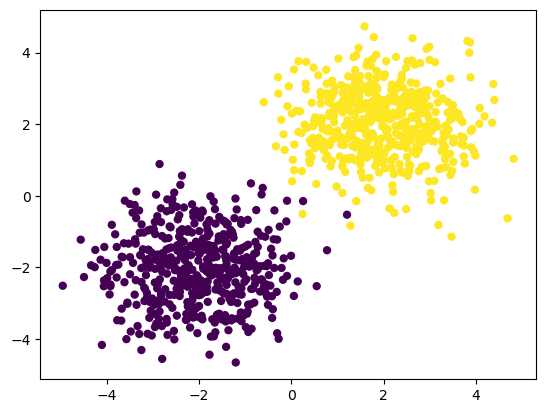

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

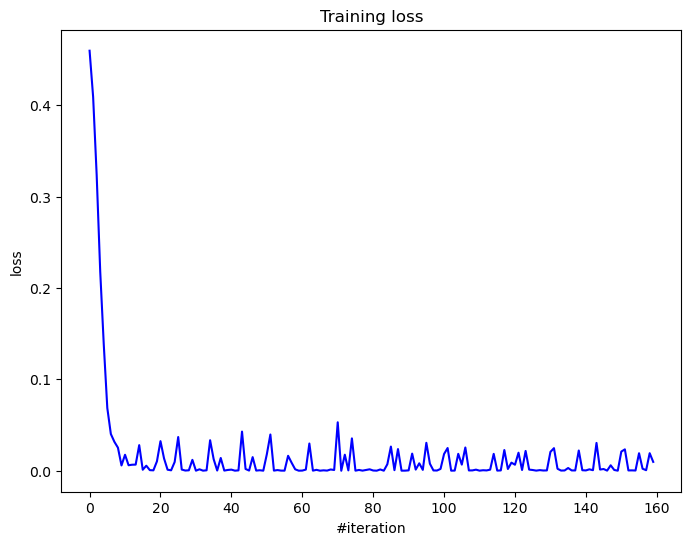

Current loss: 0.009703


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [9]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [9]:
X_train.shape

(50000, 28, 28)

In [10]:
print(y_val.shape)

(10000,)


In [11]:
X_train = X_train.reshape(-1, 784)
X_val = X_val.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [12]:
X_train.shape

(50000, 784)

One-hot encode the labels first.

In [13]:
print(y_train.shape)
y_train

(50000,)


array([5, 0, 4, ..., 8, 4, 8], dtype=uint8)

In [14]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_val = encoder.fit_transform(y_val.reshape(-1, 1))
y_test = encoder.fit_transform(y_test.reshape(-1, 1))

In [15]:
print(y_train.shape)
y_train[0, :]

(50000, 10)


array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [16]:
criterion = ClassNLLCriterion()

In [28]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epochs = 30
batch_size = 32

In [29]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [30]:
def train_model(model, train_data, val_data, loss_func, opt, n_epochs, batch_size):
    train_loss = []
    val_loss = []
    val_accuracy = []
    train_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        ep_train_accuracy = []
        
        start_time = time()
        model.train()
        for X_batch, y_batch in get_batches(train_data, batch_size):
            model.zeroGradParameters()

            # Forward
            y_pred = model.forward(X_batch)
            loss = criterion.forward(y_pred, y_batch)
            
            label_pred = y_pred.argmax(axis=1)
            label_target = y_batch.argmax(axis=1)
            ep_train_accuracy.append(np.mean((label_pred == label_target).astype(int)))
            
            # Backward
            dp = criterion.backward(y_pred, y_batch)
            model.backward(X_batch, dp)

            # Update weights
            opt(model.getParameters(), 
                         model.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            ep_train_loss.append(loss)
        
        model.evaluate()
        for X_batch, y_batch in get_batches(val_data, batch_size):
            y_pred = model.forward(X_batch)
            ep_val_loss.append(criterion.forward(y_pred, y_batch))
            label_pred = y_pred.argmax(axis=1)
            label_target = y_batch.argmax(axis=1)
            ep_val_accuracy.append(np.mean((label_pred == label_target).astype(int)))
        
        train_loss.append(np.mean(ep_train_loss))
        train_accuracy.append(np.mean(ep_train_accuracy))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        # Visualize
#         display.clear_output(wait=True)
#         plt.figure(figsize=(8, 6))

#         plt.title("Training loss")
#         plt.xlabel("#epochs")
#         plt.ylabel("loss")
#         plt.plot(train_loss, 'b', label='Train')
#         plt.plot(val_loss, 'r', label='Val')
#         plt.legend()
#         plt.show()

        print(f'Epoch {epoch + 1}/{n_epochs}, took {time() - start_time:.3f} s; ', end='')
        print(f'train loss: {train_loss[-1]:.4f}, val loss: {val_loss[-1]:.4f}; ', end='')
        print(f'train acc: {train_accuracy[-1]:.4f}, val acc: {val_accuracy[-1]:.4f}')
        
    return train_loss, val_loss, train_accuracy, val_accuracy

In [31]:
def plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, 'b', label='train')
    axes[0].plot(val_loss, 'r', label='validation')
    axes[0].legend()
    axes[0].set_xlabel('#epochs')
    axes[0].set_ylabel("loss")

    axes[1].set_title('Accuracy')
    axes[1].plot(train_accuracy, 'b', label='train')
    axes[1].plot(val_accuracy, 'r', label='validation')
    axes[1].legend()
    axes[1].set_xlabel('#epochs')
    axes[1].set_ylabel("accuracy")
    
    plt.show()

In [38]:
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epochs = 50
batch_size = 32

model = Sequential()
model.add(Linear(784, 64))
model.add(ReLU())
model.add(Linear(64, 10))
model.add(LogSoftMax())

In [39]:
train_loss, val_loss, train_accuracy, val_accuracy = train_model(model, 
        (X_train, y_train), (X_val, y_val), criterion, sgd_momentum, n_epochs, batch_size)

Epoch 1/50, took 1.763 s; train loss: 1.0059, val loss: 0.4415; train acc: 0.7631, val acc: 0.8890
Epoch 2/50, took 1.751 s; train loss: 0.4123, val loss: 0.3338; train acc: 0.8893, val acc: 0.9069
Epoch 3/50, took 1.768 s; train loss: 0.3465, val loss: 0.2993; train acc: 0.9023, val acc: 0.9174
Epoch 4/50, took 1.832 s; train loss: 0.3147, val loss: 0.2794; train acc: 0.9102, val acc: 0.9209
Epoch 5/50, took 1.918 s; train loss: 0.2928, val loss: 0.2624; train acc: 0.9170, val acc: 0.9257
Epoch 6/50, took 1.802 s; train loss: 0.2749, val loss: 0.2473; train acc: 0.9222, val acc: 0.9281
Epoch 7/50, took 1.711 s; train loss: 0.2594, val loss: 0.2360; train acc: 0.9271, val acc: 0.9328
Epoch 8/50, took 1.805 s; train loss: 0.2456, val loss: 0.2260; train acc: 0.9312, val acc: 0.9373
Epoch 9/50, took 1.821 s; train loss: 0.2336, val loss: 0.2148; train acc: 0.9343, val acc: 0.9403
Epoch 10/50, took 1.784 s; train loss: 0.2225, val loss: 0.2073; train acc: 0.9373, val acc: 0.9438
Epoch 11/

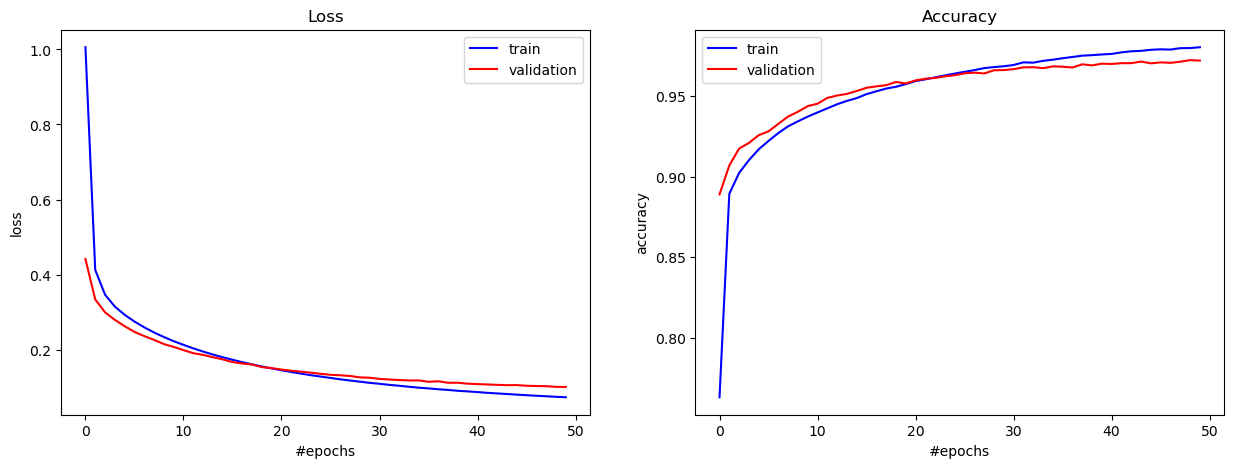

In [40]:
plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy)

In [41]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epochs = 30
batch_size = 32
n_hidden = 64

## ReLU

In [42]:
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
optimizer_state = {}

model_relu = Sequential()
model_relu.add(Linear(784, n_hidden))
model_relu.add(ReLU())
model_relu.add(Linear(n_hidden, 10))
model_relu.add(LogSoftMax())

In [43]:
train_loss_relu, val_loss_relu, train_accuracy_relu, val_accuracy_relu = train_model(model_relu, 
        (X_train, y_train), (X_val, y_val), criterion, sgd_momentum, n_epochs, batch_size)

Epoch 1/30, took 1.665 s; train loss: 1.0027, val loss: 0.4356; train acc: 0.7659, val acc: 0.8906
Epoch 2/30, took 1.761 s; train loss: 0.4123, val loss: 0.3346; train acc: 0.8870, val acc: 0.9083
Epoch 3/30, took 1.793 s; train loss: 0.3477, val loss: 0.2997; train acc: 0.9014, val acc: 0.9116
Epoch 4/30, took 1.760 s; train loss: 0.3153, val loss: 0.2764; train acc: 0.9104, val acc: 0.9219
Epoch 5/30, took 1.817 s; train loss: 0.2920, val loss: 0.2606; train acc: 0.9169, val acc: 0.9268
Epoch 6/30, took 1.819 s; train loss: 0.2734, val loss: 0.2470; train acc: 0.9230, val acc: 0.9306
Epoch 7/30, took 1.801 s; train loss: 0.2576, val loss: 0.2341; train acc: 0.9271, val acc: 0.9347
Epoch 8/30, took 1.809 s; train loss: 0.2440, val loss: 0.2259; train acc: 0.9311, val acc: 0.9362
Epoch 9/30, took 1.829 s; train loss: 0.2319, val loss: 0.2134; train acc: 0.9349, val acc: 0.9404
Epoch 10/30, took 1.753 s; train loss: 0.2205, val loss: 0.2048; train acc: 0.9378, val acc: 0.9432
Epoch 11/

### Relu + BN

In [44]:
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
optimizer_state = {}

model_relu_bn = Sequential()
model_relu_bn.add(Linear(784, n_hidden))
model_relu_bn.add(BatchNormalization())
model_relu_bn.add(ChannelwiseScaling(n_hidden))
model_relu_bn.add(ReLU())
model_relu_bn.add(Linear(n_hidden, 10))
model_relu_bn.add(LogSoftMax())

In [45]:
train_loss_relu_bn, val_loss_relu_bn, train_accuracy_relu_bn, val_accuracy_relu_bn = train_model(model_relu_bn, 
        (X_train, y_train), (X_val, y_val), criterion, sgd_momentum, n_epochs, batch_size)

Epoch 1/30, took 2.264 s; train loss: 1.6896, val loss: 0.7762; train acc: 0.6075, val acc: 0.7975
Epoch 2/30, took 2.232 s; train loss: 0.5179, val loss: 0.3532; train acc: 0.8838, val acc: 0.9000
Epoch 3/30, took 2.252 s; train loss: 0.3535, val loss: 0.2833; train acc: 0.9039, val acc: 0.9230
Epoch 4/30, took 2.251 s; train loss: 0.3019, val loss: 0.2955; train acc: 0.9138, val acc: 0.9172
Epoch 5/30, took 2.217 s; train loss: 0.2717, val loss: 0.2879; train acc: 0.9229, val acc: 0.9173
Epoch 6/30, took 2.205 s; train loss: 0.2491, val loss: 0.3618; train acc: 0.9289, val acc: 0.8880
Epoch 7/30, took 2.200 s; train loss: 0.2305, val loss: 0.2382; train acc: 0.9342, val acc: 0.9310
Epoch 8/30, took 2.315 s; train loss: 0.2168, val loss: 0.2096; train acc: 0.9374, val acc: 0.9403
Epoch 9/30, took 2.199 s; train loss: 0.2007, val loss: 0.2152; train acc: 0.9429, val acc: 0.9404
Epoch 10/30, took 2.278 s; train loss: 0.1897, val loss: 0.2417; train acc: 0.9462, val acc: 0.9242
Epoch 11/

## ELU

In [46]:
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
optimizer_state = {}

model_elu = Sequential()
model_elu.add(Linear(784, n_hidden))
model_elu.add(ELU())
model_elu.add(Linear(n_hidden, 10))
model_elu.add(LogSoftMax())

In [47]:
train_loss_elu, val_loss_elu, train_accuracy_elu, val_accuracy_elu = train_model(model_elu, 
        (X_train, y_train), (X_val, y_val), criterion, sgd_momentum, n_epochs, batch_size)

Epoch 1/30, took 1.849 s; train loss: 0.9344, val loss: 0.4311; train acc: 0.7916, val acc: 0.8890
Epoch 2/30, took 1.925 s; train loss: 0.4112, val loss: 0.3401; train acc: 0.8871, val acc: 0.9045
Epoch 3/30, took 1.942 s; train loss: 0.3534, val loss: 0.3088; train acc: 0.8996, val acc: 0.9115
Epoch 4/30, took 1.860 s; train loss: 0.3279, val loss: 0.2945; train acc: 0.9058, val acc: 0.9168
Epoch 5/30, took 1.872 s; train loss: 0.3112, val loss: 0.2836; train acc: 0.9118, val acc: 0.9187
Epoch 6/30, took 1.768 s; train loss: 0.2985, val loss: 0.2746; train acc: 0.9147, val acc: 0.9218
Epoch 7/30, took 1.874 s; train loss: 0.2877, val loss: 0.2635; train acc: 0.9181, val acc: 0.9261
Epoch 8/30, took 2.003 s; train loss: 0.2777, val loss: 0.2553; train acc: 0.9217, val acc: 0.9275
Epoch 9/30, took 2.229 s; train loss: 0.2681, val loss: 0.2486; train acc: 0.9244, val acc: 0.9293
Epoch 10/30, took 2.073 s; train loss: 0.2592, val loss: 0.2405; train acc: 0.9268, val acc: 0.9319
Epoch 11/

### ELU + BN

In [48]:
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
optimizer_state = {}

model_elu_bn = Sequential()
model_elu_bn.add(Linear(784, n_hidden))
model_elu_bn.add(BatchNormalization(0.5))
model_elu_bn.add(ChannelwiseScaling(n_hidden))
model_elu_bn.add(ELU())
model_elu_bn.add(Linear(n_hidden, 10))
model_elu_bn.add(LogSoftMax())

In [49]:
train_loss_elu_bn, val_loss_elu_bn, train_accuracy_elu_bn, val_accuracy_elu_bn = train_model(model_elu_bn, 
        (X_train, y_train), (X_val, y_val), criterion, sgd_momentum, n_epochs, batch_size)

Epoch 1/30, took 2.289 s; train loss: 1.3402, val loss: 0.4859; train acc: 0.7198, val acc: 0.8984
Epoch 2/30, took 2.362 s; train loss: 0.4423, val loss: 0.3338; train acc: 0.8890, val acc: 0.9087
Epoch 3/30, took 2.345 s; train loss: 0.3534, val loss: 0.2799; train acc: 0.9017, val acc: 0.9234
Epoch 4/30, took 2.310 s; train loss: 0.3171, val loss: 0.2672; train acc: 0.9096, val acc: 0.9263
Epoch 5/30, took 2.255 s; train loss: 0.2912, val loss: 0.2443; train acc: 0.9170, val acc: 0.9330
Epoch 6/30, took 2.339 s; train loss: 0.2705, val loss: 0.2459; train acc: 0.9222, val acc: 0.9304
Epoch 7/30, took 2.274 s; train loss: 0.2521, val loss: 0.2235; train acc: 0.9280, val acc: 0.9370
Epoch 8/30, took 2.259 s; train loss: 0.2377, val loss: 0.2094; train acc: 0.9333, val acc: 0.9433
Epoch 9/30, took 2.264 s; train loss: 0.2230, val loss: 0.2065; train acc: 0.9359, val acc: 0.9408
Epoch 10/30, took 2.295 s; train loss: 0.2102, val loss: 0.1804; train acc: 0.9401, val acc: 0.9505
Epoch 11/

### LeakyReLU

In [50]:
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
optimizer_state = {}

model_lrelu = Sequential()
model_lrelu.add(Linear(784, n_hidden))
model_lrelu.add(LeakyReLU())
model_lrelu.add(Linear(n_hidden, 10))
model_lrelu.add(LogSoftMax())

In [51]:
train_loss_lrelu, val_loss_lrelu, train_accuracy_lrelu, val_accuracy_lrelu = train_model(model_lrelu, 
        (X_train, y_train), (X_val, y_val), criterion, sgd_momentum, n_epochs, batch_size)

Epoch 1/30, took 1.888 s; train loss: 0.9797, val loss: 0.4300; train acc: 0.7661, val acc: 0.8904
Epoch 2/30, took 1.875 s; train loss: 0.4072, val loss: 0.3324; train acc: 0.8887, val acc: 0.9086
Epoch 3/30, took 1.828 s; train loss: 0.3439, val loss: 0.2976; train acc: 0.9024, val acc: 0.9174
Epoch 4/30, took 1.856 s; train loss: 0.3131, val loss: 0.2764; train acc: 0.9112, val acc: 0.9224
Epoch 5/30, took 1.873 s; train loss: 0.2916, val loss: 0.2632; train acc: 0.9173, val acc: 0.9256
Epoch 6/30, took 1.821 s; train loss: 0.2746, val loss: 0.2477; train acc: 0.9220, val acc: 0.9296
Epoch 7/30, took 1.855 s; train loss: 0.2605, val loss: 0.2367; train acc: 0.9266, val acc: 0.9333
Epoch 8/30, took 1.883 s; train loss: 0.2474, val loss: 0.2274; train acc: 0.9303, val acc: 0.9361
Epoch 9/30, took 1.825 s; train loss: 0.2360, val loss: 0.2231; train acc: 0.9345, val acc: 0.9382
Epoch 10/30, took 1.864 s; train loss: 0.2257, val loss: 0.2096; train acc: 0.9374, val acc: 0.9415
Epoch 11/

### LeakyReLU + BN

In [52]:
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
optimizer_state = {}

model_lrelu_bn = Sequential()
model_lrelu_bn.add(Linear(784, n_hidden))
model_lrelu_bn.add(BatchNormalization(0.5))
model_lrelu_bn.add(ChannelwiseScaling(n_hidden))
model_lrelu_bn.add(LeakyReLU())
model_lrelu_bn.add(Linear(n_hidden, 10))
model_lrelu_bn.add(LogSoftMax())

In [53]:
train_loss_lrelu_bn, val_loss_lrelu_bn, train_accuracy_lrelu_bn, val_accuracy_lrelu_bn = train_model(model_lrelu_bn, 
        (X_train, y_train), (X_val, y_val), criterion, sgd_momentum, n_epochs, batch_size)

Epoch 1/30, took 2.435 s; train loss: 1.7165, val loss: 0.7056; train acc: 0.6103, val acc: 0.8749
Epoch 2/30, took 2.324 s; train loss: 0.5284, val loss: 0.3671; train acc: 0.8798, val acc: 0.9012
Epoch 3/30, took 2.371 s; train loss: 0.3569, val loss: 0.2691; train acc: 0.9029, val acc: 0.9268
Epoch 4/30, took 2.376 s; train loss: 0.3062, val loss: 0.2397; train acc: 0.9135, val acc: 0.9349
Epoch 5/30, took 2.444 s; train loss: 0.2746, val loss: 0.2189; train acc: 0.9219, val acc: 0.9414
Epoch 6/30, took 2.357 s; train loss: 0.2495, val loss: 0.2080; train acc: 0.9288, val acc: 0.9425
Epoch 7/30, took 2.347 s; train loss: 0.2317, val loss: 0.2054; train acc: 0.9338, val acc: 0.9430
Epoch 8/30, took 2.343 s; train loss: 0.2150, val loss: 0.1925; train acc: 0.9383, val acc: 0.9467
Epoch 9/30, took 2.303 s; train loss: 0.2038, val loss: 0.1825; train acc: 0.9412, val acc: 0.9479
Epoch 10/30, took 2.416 s; train loss: 0.1893, val loss: 0.2043; train acc: 0.9461, val acc: 0.9420
Epoch 11/

### SoftPlus

In [54]:
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
optimizer_state = {}

model_softplus = Sequential()
model_softplus.add(Linear(784, n_hidden))
model_softplus.add(SoftPlus())
model_softplus.add(Linear(n_hidden, 10))
model_softplus.add(LogSoftMax())

In [55]:
train_loss_softplus, val_loss_softplus, train_accuracy_softplus, val_accuracy_softplus = train_model(model_softplus, 
        (X_train, y_train), (X_val, y_val), criterion, sgd_momentum, n_epochs, batch_size)

Epoch 1/30, took 1.933 s; train loss: 1.2417, val loss: 0.5123; train acc: 0.7078, val acc: 0.8693
Epoch 2/30, took 1.878 s; train loss: 0.4562, val loss: 0.3634; train acc: 0.8762, val acc: 0.8984
Epoch 3/30, took 1.924 s; train loss: 0.3738, val loss: 0.3249; train acc: 0.8936, val acc: 0.9073
Epoch 4/30, took 1.909 s; train loss: 0.3425, val loss: 0.3044; train acc: 0.9016, val acc: 0.9136
Epoch 5/30, took 1.902 s; train loss: 0.3249, val loss: 0.2912; train acc: 0.9065, val acc: 0.9172
Epoch 6/30, took 1.940 s; train loss: 0.3125, val loss: 0.2848; train acc: 0.9107, val acc: 0.9180
Epoch 7/30, took 1.901 s; train loss: 0.3031, val loss: 0.2774; train acc: 0.9129, val acc: 0.9201
Epoch 8/30, took 2.011 s; train loss: 0.2952, val loss: 0.2737; train acc: 0.9157, val acc: 0.9213
Epoch 9/30, took 1.962 s; train loss: 0.2887, val loss: 0.2698; train acc: 0.9181, val acc: 0.9216
Epoch 10/30, took 2.176 s; train loss: 0.2820, val loss: 0.2628; train acc: 0.9197, val acc: 0.9262
Epoch 11/

### SoftPlus + BN

In [56]:
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
optimizer_state = {}

model_softplus_bn = Sequential()
model_softplus_bn.add(Linear(784, n_hidden))
model_softplus_bn.add(BatchNormalization(0.5))
model_softplus_bn.add(ChannelwiseScaling(n_hidden))
model_softplus_bn.add(SoftPlus())
model_softplus_bn.add(Linear(n_hidden, 10))
model_softplus_bn.add(LogSoftMax())

In [57]:
train_loss_softplus_bn, val_loss_softplus_bn, train_accuracy_softplus_bn, val_accuracy_softplus_bn = train_model(
    model_softplus_bn, 
        (X_train, y_train), (X_val, y_val), criterion, sgd_momentum, n_epochs, batch_size)

Epoch 1/30, took 2.514 s; train loss: 1.9578, val loss: 1.2408; train acc: 0.5258, val acc: 0.8134
Epoch 2/30, took 2.359 s; train loss: 0.7515, val loss: 0.4459; train acc: 0.8610, val acc: 0.8947
Epoch 3/30, took 2.391 s; train loss: 0.4200, val loss: 0.3201; train acc: 0.8921, val acc: 0.9146
Epoch 4/30, took 2.311 s; train loss: 0.3501, val loss: 0.2859; train acc: 0.9044, val acc: 0.9219
Epoch 5/30, took 2.301 s; train loss: 0.3150, val loss: 0.2640; train acc: 0.9112, val acc: 0.9278
Epoch 6/30, took 2.307 s; train loss: 0.2905, val loss: 0.2353; train acc: 0.9185, val acc: 0.9346
Epoch 7/30, took 2.354 s; train loss: 0.2697, val loss: 0.2329; train acc: 0.9235, val acc: 0.9347
Epoch 8/30, took 2.388 s; train loss: 0.2525, val loss: 0.2195; train acc: 0.9283, val acc: 0.9397
Epoch 9/30, took 2.345 s; train loss: 0.2368, val loss: 0.2006; train acc: 0.9323, val acc: 0.9456
Epoch 10/30, took 2.363 s; train loss: 0.2256, val loss: 0.1958; train acc: 0.9359, val acc: 0.9463
Epoch 11/

## Comparison

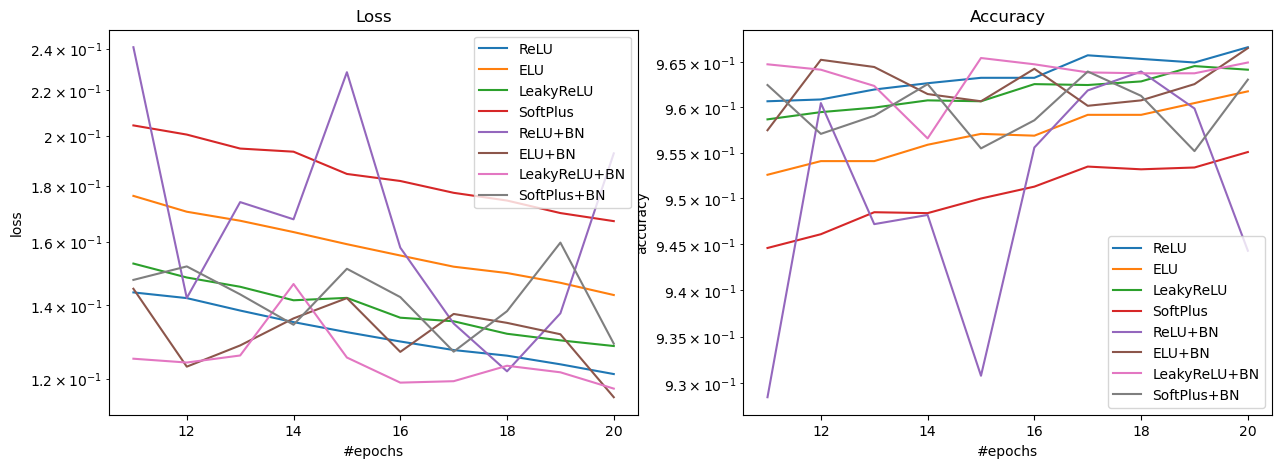

In [58]:
b, e = -10, None
x = np.arange(1, n_epochs+1)[b:e]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].set_title('Loss')
axes[0].plot(x, val_loss_relu[b:e], label='ReLU')
axes[0].plot(x, val_loss_elu[b:e], label='ELU')
axes[0].plot(x, val_loss_lrelu[b:e], label='LeakyReLU')
axes[0].plot(x, val_loss_softplus[b:e], label='SoftPlus')
axes[0].plot(x, val_loss_relu_bn[b:e], label='ReLU+BN')
axes[0].plot(x, val_loss_elu_bn[b:e], label='ELU+BN')
axes[0].plot(x, val_loss_lrelu_bn[b:e], label='LeakyReLU+BN')
axes[0].plot(x, val_loss_softplus_bn[b:e], label='SoftPlus+BN')
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_xlabel('#epochs')
axes[0].set_ylabel("loss")

axes[1].set_title('Accuracy')
axes[1].plot(x, val_accuracy_relu[b:e], label='ReLU')
axes[1].plot(x, val_accuracy_elu[b:e], label='ELU')
axes[1].plot(x, val_accuracy_lrelu[b:e], label='LeakyReLU')
axes[1].plot(x, val_accuracy_softplus[b:e], label='SoftPlus')
axes[1].plot(x, val_accuracy_relu_bn[b:e], label='ReLU+BN')
axes[1].plot(x, val_accuracy_elu_bn[b:e], label='ELU+BN')
axes[1].plot(x, val_accuracy_lrelu_bn[b:e], label='LeakyReLU+BN')
axes[1].plot(x, val_accuracy_softplus_bn[b:e], label='SoftPlus+BN')
axes[1].legend()
axes[1].set_yscale('log')
axes[1].set_xlabel('#epochs')
axes[1].set_ylabel("accuracy")

plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

Из полученных графиков видно, что практически все функции активации дают близкие результаты как по лоссу, так и по accuracy. При этом все же наилучшую точность показывают ReLU, LeakyRelU+BN, ELU+BN. При этом по скорости вычисления ReLU является самой быстрой.

Batch Normalization помогает для всех функций активации, кроме ReLU. Интересно, что для всех функций активации добавление BN увеличивает флуктуации лосса и accuracy во время процесса обучения. 

### SGD

In [59]:
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epochs = 40
batch_size = 32
n_hidden = 64


model_sgd = Sequential()
model_sgd.add(Linear(784, n_hidden))
model_sgd.add(ReLU())
model_sgd.add(Linear(n_hidden, 10))
model_sgd.add(LogSoftMax())

In [60]:
train_loss_sgd, val_loss_sgd, train_accuracy_sgd, val_accuracy_sgd = train_model(model_sgd, 
        (X_train, y_train), (X_val, y_val), criterion, sgd_momentum, n_epochs, batch_size)

Epoch 1/40, took 1.841 s; train loss: 1.0042, val loss: 0.4408; train acc: 0.7659, val acc: 0.8891
Epoch 2/40, took 1.936 s; train loss: 0.4141, val loss: 0.3368; train acc: 0.8876, val acc: 0.9088
Epoch 3/40, took 2.038 s; train loss: 0.3496, val loss: 0.3035; train acc: 0.9020, val acc: 0.9141
Epoch 4/40, took 1.920 s; train loss: 0.3192, val loss: 0.2842; train acc: 0.9089, val acc: 0.9192
Epoch 5/40, took 2.003 s; train loss: 0.2977, val loss: 0.2679; train acc: 0.9156, val acc: 0.9235
Epoch 6/40, took 1.920 s; train loss: 0.2799, val loss: 0.2555; train acc: 0.9200, val acc: 0.9265
Epoch 7/40, took 1.857 s; train loss: 0.2647, val loss: 0.2424; train acc: 0.9257, val acc: 0.9305
Epoch 8/40, took 1.865 s; train loss: 0.2508, val loss: 0.2308; train acc: 0.9292, val acc: 0.9350
Epoch 9/40, took 1.847 s; train loss: 0.2385, val loss: 0.2196; train acc: 0.9330, val acc: 0.9371
Epoch 10/40, took 1.853 s; train loss: 0.2271, val loss: 0.2102; train acc: 0.9363, val acc: 0.9419
Epoch 11/

### Adam

In [61]:
optimizer_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-9}
optimizer_state = {}

# Looping params
n_epochs = 40
batch_size = 32
n_hidden = 64


model_adam = Sequential()
model_adam.add(Linear(784, n_hidden))
model_adam.add(ReLU())
model_adam.add(Linear(n_hidden, 10))
model_adam.add(LogSoftMax())

In [62]:
train_loss_adam, val_loss_adam, train_accuracy_adam, val_accuracy_adam = train_model(model_adam, 
        (X_train, y_train), (X_val, y_val), criterion, adam_optimizer, n_epochs, batch_size)

Epoch 1/40, took 2.167 s; train loss: 0.3733, val loss: 0.2030; train acc: 0.8977, val acc: 0.9421
Epoch 2/40, took 2.175 s; train loss: 0.1912, val loss: 0.1563; train acc: 0.9443, val acc: 0.9556
Epoch 3/40, took 2.244 s; train loss: 0.1387, val loss: 0.1414; train acc: 0.9598, val acc: 0.9582
Epoch 4/40, took 2.213 s; train loss: 0.1094, val loss: 0.1111; train acc: 0.9676, val acc: 0.9675
Epoch 5/40, took 2.186 s; train loss: 0.0897, val loss: 0.1130; train acc: 0.9733, val acc: 0.9667
Epoch 6/40, took 2.221 s; train loss: 0.0748, val loss: 0.1032; train acc: 0.9777, val acc: 0.9703
Epoch 7/40, took 2.220 s; train loss: 0.0640, val loss: 0.0956; train acc: 0.9812, val acc: 0.9708
Epoch 8/40, took 2.088 s; train loss: 0.0543, val loss: 0.0947; train acc: 0.9832, val acc: 0.9718
Epoch 9/40, took 2.208 s; train loss: 0.0467, val loss: 0.0918; train acc: 0.9855, val acc: 0.9726
Epoch 10/40, took 2.198 s; train loss: 0.0409, val loss: 0.1001; train acc: 0.9876, val acc: 0.9704
Epoch 11/

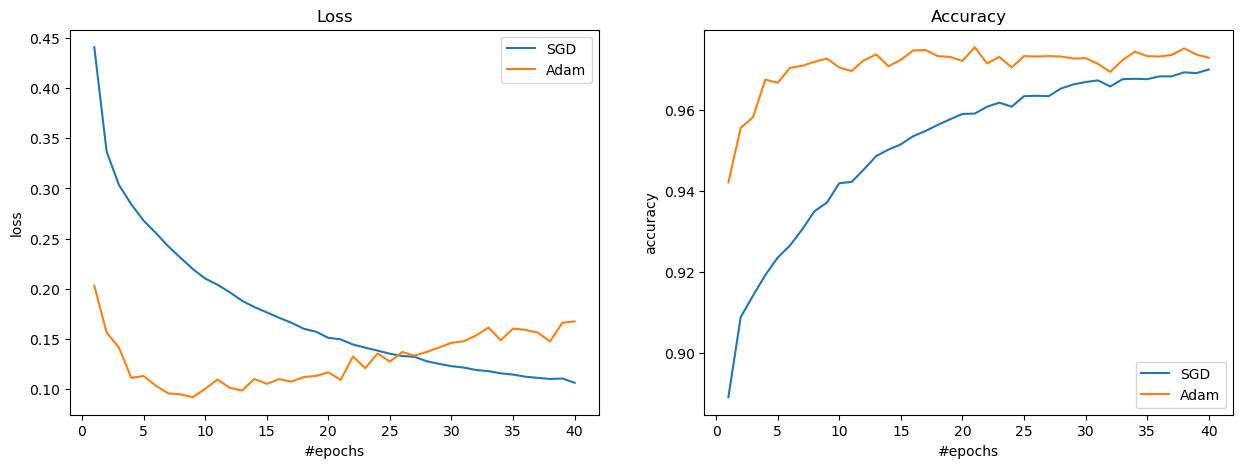

In [63]:
b, e = 0, None
x = np.arange(1, n_epochs+1)[b:e]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].set_title('Loss')
axes[0].plot(x, val_loss_sgd[b:e], label='SGD')
axes[0].plot(x, val_loss_adam[b:e], label='Adam')
axes[0].legend()
#axes[0].set_yscale('log')
axes[0].set_xlabel('#epochs')
axes[0].set_ylabel("loss")

axes[1].set_title('Accuracy')
axes[1].plot(x, val_accuracy_sgd[b:e], label='SGD')
axes[1].plot(x, val_accuracy_adam[b:e], label='Adam')
axes[1].legend()
#axes[1].set_yscale('log')
axes[1].set_xlabel('#epochs')
axes[1].set_ylabel("accuracy")

plt.show()

При данных параметрах оптимизации и learning rate Adam позоляет сети обучиться быстрее и достичь большей accuracy, чем когда используется SGD. На графиках для Adam даже заметен процесс переобучения.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

## Best Model

In [76]:
optimizer_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-9}
optimizer_state = {}

n_epochs = 30
batch_size = 32
n_hidden = 128

model_best = Sequential()
model_best.add(Linear(784, n_hidden))
model_best.add(Dropout(0.5))
model_best.add(ReLU())
model_best.add(Linear(n_hidden, 10))
model_best.add(Dropout(0.1))
model_best.add(LogSoftMax())

In [77]:
train_loss_best, val_loss_best, train_accuracy_best, val_accuracy_best = train_model(model_best, 
        (X_train, y_train), (X_val, y_val), criterion, adam_optimizer, n_epochs, batch_size)

Epoch 1/30, took 3.361 s; train loss: 0.5587, val loss: 0.1951; train acc: 0.8227, val acc: 0.9468
Epoch 2/30, took 3.628 s; train loss: 0.3523, val loss: 0.1471; train acc: 0.8834, val acc: 0.9574
Epoch 3/30, took 3.353 s; train loss: 0.3098, val loss: 0.1297; train acc: 0.8944, val acc: 0.9640
Epoch 4/30, took 3.655 s; train loss: 0.2827, val loss: 0.1180; train acc: 0.9013, val acc: 0.9663
Epoch 5/30, took 3.565 s; train loss: 0.2632, val loss: 0.1064; train acc: 0.9074, val acc: 0.9699
Epoch 6/30, took 2.920 s; train loss: 0.2534, val loss: 0.1070; train acc: 0.9087, val acc: 0.9707
Epoch 7/30, took 2.935 s; train loss: 0.2409, val loss: 0.1028; train acc: 0.9137, val acc: 0.9724
Epoch 8/30, took 2.928 s; train loss: 0.2320, val loss: 0.0979; train acc: 0.9148, val acc: 0.9742
Epoch 9/30, took 3.152 s; train loss: 0.2280, val loss: 0.0977; train acc: 0.9144, val acc: 0.9738
Epoch 10/30, took 2.946 s; train loss: 0.2203, val loss: 0.0922; train acc: 0.9174, val acc: 0.9762
Epoch 11/

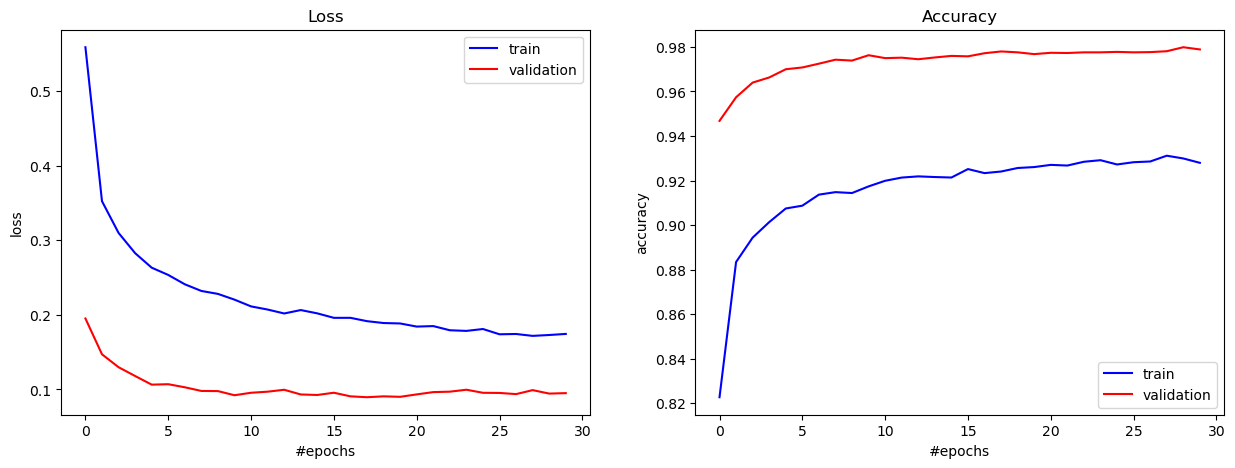

In [78]:
plot_train_process(train_loss_best, val_loss_best, train_accuracy_best, val_accuracy_best)

Print here your accuracy on test set. It should be around 90%.

In [79]:
def eval_model(model, test_data, batch_size):
    test_accuracy = []
    
    model.evaluate()
    for X_batch, y_batch in get_batches(test_data, batch_size):
        y_pred = model.forward(X_batch)
        y_pred = y_pred.argmax(axis=1)
        y_batch = y_batch.argmax(axis=1)
        test_accuracy.append(np.mean((y_pred == y_batch).astype(int)))

    accuracy = np.mean(test_accuracy)
    return accuracy
    

In [80]:
print(f'Test accuracy: {eval_model(model_best, (X_test, y_test), 32):.4f}')

Test accuracy: 0.9764


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [81]:
import torch
from torch import nn
from torch.nn import functional as F

In [82]:
from torch.utils.data import Dataset, DataLoader

class TorchDataset(Dataset):
    def __init__(self, X_train, y_train):
        self.X_train = torch.Tensor(X_train)
        self.y_train = torch.Tensor(y_train)

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]


In [83]:
train_data_torch = TorchDataset(X_train, y_train)
test_data_torch = TorchDataset(X_test, y_test)
val_data_torch = TorchDataset(X_val, y_val)

In [90]:
def train(model, train_loader, val_loader, loss_func, opt, n_epochs):
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_train_accuracy = []
        ep_val_accuracy = []
        
        start_time = time()
        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            
            label_pred = y_pred.argmax(dim=1)
            label_target = y_batch.argmax(dim=1)
            ep_train_accuracy.append((label_pred == label_target).float().mean())
            
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            loss = loss_func(y_pred, label_target) # for NLLLoss
            loss.backward()
            opt.step()
            opt.zero_grad()
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # compute predictions
                y_pred = model(X_batch)
                label_pred = y_pred.argmax(dim=1)
                label_target = y_batch.argmax(dim=1)
                ep_val_loss.append(loss_func(y_pred, label_target).item())  # for NLLLoss
                ep_val_accuracy.append((label_pred == label_target).float().mean())

        
        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        train_accuracy.append(np.mean(ep_train_accuracy))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        # print the results for this epoch:
        print(f'Epoch {epoch + 1}/{n_epochs}, took {time() - start_time:.3f} s; ', end='')
        print(f'train loss: {train_loss[-1]:.4f}, val loss: {val_loss[-1]:.4f}; ', end='')
        print(f'train acc: {train_accuracy[-1]:.4f}, val acc: {val_accuracy[-1]:.4f}')

    return train_loss, val_loss, train_accuracy, val_accuracy

In [91]:
def validation(model, test_loader):
    test_accuracy = []
    
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model.forward(X_batch)
            label_pred = y_pred.argmax(axis=1)
            label_target = y_batch.argmax(axis=1)
            test_accuracy.append((label_pred == label_target).float().mean())

    accuracy = np.mean(test_accuracy)
    return accuracy
    

In [92]:
loss_func = nn.NLLLoss()

In [98]:
# Creating model instance

n_epochs = 20
batch_size = 32
n_hidden = 128

model_torch = nn.Sequential(
    nn.Linear(28*28, n_hidden),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(n_hidden, 10),
    nn.LogSoftmax(dim=1)
)

opt = torch.optim.Adam(model_torch.parameters(), lr=1e-3)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_torch.to(device, torch.float32)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): Dropout(p=0.5, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=10, bias=True)
  (4): LogSoftmax(dim=1)
)

In [99]:
train_loader = DataLoader(train_data_torch, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data_torch, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data_torch, batch_size=batch_size, shuffle=False)

In [100]:
train_loss_torch, val_loss_torch, train_accuracy_torch, val_accuracy_torch = train(
    model_torch, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1/20, took 2.620 s; train loss: 0.4442, val loss: 0.1887; train acc: 0.8734, val acc: 0.9476
Epoch 2/20, took 2.630 s; train loss: 0.2503, val loss: 0.1399; train acc: 0.9262, val acc: 0.9619
Epoch 3/20, took 2.692 s; train loss: 0.2072, val loss: 0.1126; train acc: 0.9388, val acc: 0.9690
Epoch 4/20, took 2.837 s; train loss: 0.1792, val loss: 0.1036; train acc: 0.9457, val acc: 0.9705
Epoch 5/20, took 2.649 s; train loss: 0.1644, val loss: 0.0992; train acc: 0.9513, val acc: 0.9719
Epoch 6/20, took 2.674 s; train loss: 0.1533, val loss: 0.0950; train acc: 0.9534, val acc: 0.9722
Epoch 7/20, took 2.709 s; train loss: 0.1448, val loss: 0.0897; train acc: 0.9562, val acc: 0.9738
Epoch 8/20, took 2.808 s; train loss: 0.1325, val loss: 0.0859; train acc: 0.9591, val acc: 0.9761
Epoch 9/20, took 2.704 s; train loss: 0.1269, val loss: 0.0860; train acc: 0.9594, val acc: 0.9747
Epoch 10/20, took 3.013 s; train loss: 0.1235, val loss: 0.0830; train acc: 0.9605, val acc: 0.9760
Epoch 11/

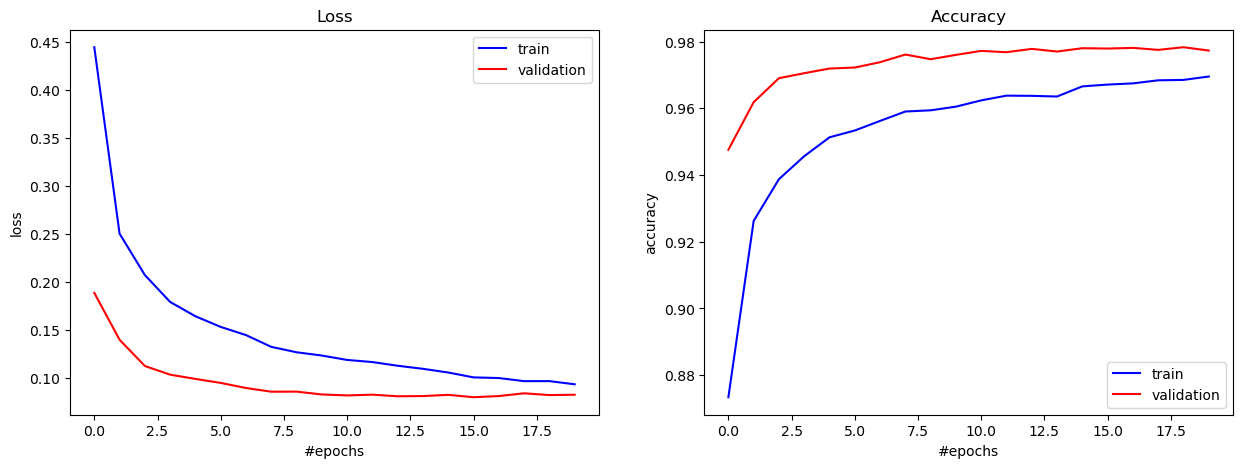

In [101]:
plot_train_process(train_loss_torch, val_loss_torch, train_accuracy_torch, val_accuracy_torch)

In [102]:
print(f'Test accuracy: {validation(model_torch, test_loader):.4f}')

Test accuracy: 0.9758
